# 1. Imports

In [46]:
import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from unidecode import unidecode

import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
%matplotlib inline

# 2. Leitura da base de dados

In [2]:
df = pd.read_excel('Desafio_ciencia_de_dados.xlsm')

In [3]:
df.head()

,name,description,employees,total_funding,city,subcountry,lat,lng
0,fitin,fitin is the latest fit tech platform that pro...,1,NaN,toronto,ontario,43.70011,-79.416300
1,quinditech,our services include independent & collaborati...,10,NaN,montreal,quebec,45.50884,-73.587810
2,botfirst,chatlanding is a digital chatbot platform wher...,1,NaN,toronto,ontario,43.70011,-79.416300
3,bravver,ai-powered army of health professionals in you...,1,NaN,quebec,quebec,46.82596,-71.235223
4,stylify,stylify is a mobile platform that connects peo...,1,NaN,toronto,ontario,43.70011,-79.416300


In [4]:
df.shape

(21292, 8)

# 3. Pre processamento

## 3.1 Juntando nome da empresa com descrição

In [5]:
df['name_description'] = df.apply(lambda row: str(row['name']) + ' ' + str(row['description']), axis=1)

## 3.2 Retirando pontuações do texto

In [6]:
pontuacao = r'[/.!$%^&#*+\'\"()-.,:;<=>?@[\]{}|]'

In [7]:
df['name_description'] = df['name_description'].apply(lambda row: re.sub(pontuacao, ' ', row))

## 3.3 Retirando caracteres numéricos

In [8]:
numeros = r'[0-9]'

In [9]:
df['name_description'] = df['name_description'].apply(lambda row: re.sub(numeros, ' ', row))

## 3.4 Deixando o texto em letras minúsculas

In [10]:
df['name_description'] = df['name_description'].apply(lambda row: row.lower())

## 3.5 Retirando quaisquer acentuações

In [11]:
df['name_description'] = df['name_description'].apply(lambda row: unidecode(row))

## 3.6 Retirando caracteres especiais

In [12]:
def remover_caracteres_especiais(texto):
    # Substituir outros caracteres de escape Unicode, como \uXXXX e \UXXXXXXXX, por espaços em branco
    texto_limpo = re.sub(r'\\[uU][0-9A-Fa-f]+', ' ', texto)
    
    # Remove caracteres na lista substituindo por espaços vazios
    palavras = ['\n', '\t', '\r', '\f', '\v']
    for palavra in palavras:
        texto_limpo = texto_limpo.replace(palavra, ' ')
    
    return texto_limpo

In [13]:
df['name_description'] = df['name_description'].apply(lambda row: remover_caracteres_especiais(row))

## 3.7 Retirando stopwords

In [14]:
stopwords = nltk.corpus.stopwords.words('english')

In [15]:
df['name_description'] = df['name_description'].apply(lambda row:' '.join([palavra for palavra in row.split() 
                                                                                     if len(palavra) >= 1 and 
                                                                                     palavra not in stopwords]))

## 3.8 Retirando espaços extras

In [16]:
def remover_espacos_extras(texto):
    # O padrão \s+ corresponde a um ou mais espaços em branco
    # e o substitui por um único espaço
    return re.sub(r'\s+', ' ', texto).strip()

df['name_description'] = df['name_description'].apply(lambda row: remover_espacos_extras(row))

# 4. Aplicando técnicas

## 4.1 BERTopic

In [17]:
vectorizer = CountVectorizer(ngram_range=(1,2))

In [18]:
textos = df['name_description'].to_list()

In [19]:
model = BERTopic(
    vectorizer_model=vectorizer, 
    language='english',
    calculate_probabilities=True,
    top_n_words=5,
    min_topic_size=5,
    verbose=True
)

In [20]:
topicos, probs = model.fit_transform(textos)

2024-01-13 17:26:58,515 - BERTopic - Transformed documents to Embeddings


2024-01-13 17:27:22,374 - BERTopic - Reduced dimensionality
2024-01-13 17:31:33,574 - BERTopic - Clustered reduced embeddings


## 4.2 Gravando tópicos e gerando df com principais palavras

In [21]:
df['topicos']=topicos

In [22]:
freq = model.get_topic_info()

In [35]:
freq.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,8750,-1_business_technology_data_marketing,"[business, technology, data, marketing, software]",[technophile technophile specialises business ...
1,0,991,0_gold_exploration_mineral_mining,"[gold, exploration, mineral, mining, resources]",[rokmaster resources corp rokmaster resources ...
2,1,393,1_students_teachers_student_learning,"[students, teachers, student, learning, educat...",[campusmate inc today students forced rely tea...
3,2,340,2_food_restaurant_restaurants_meal,"[food, restaurant, restaurants, meal, meals]",[skipthedishes skipthedishes one north america...
4,3,250,3_fashion_clothing_women_apparel,"[fashion, clothing, women, apparel, men]",[bond enterprise bondanddeni com sell clothing...


In [36]:
freq.shape

(410, 5)

## 4.3 Tópicos relacionados ao assunto de interesse

In [25]:
freq[freq['Representation'].astype(str).str.contains('water')]

,Topic,Count,Name,Representation,Representative_Docs
73,72,40,72_water_wastewater_membrane_treatment,"[water, wastewater, membrane, treatment, waste...",[aqua air waste r door water vending electroni...
133,132,21,132_energy_smart home_water_grid,"[energy, smart home, water, grid, homebeaver]",[ubios ai ubios ai helps residential multi ten...
287,286,8,286_water_esplash_contaminants_detect,"[water, esplash, contaminants, detect, fred]",[quantwave technologies quantwave integrates m...


In [33]:
freq['Representation'][287]

['water', 'esplash', 'contaminants', 'detect', 'fred']

In [34]:
# observação: os números dos tópicos variam ao rodar o algoritimo novamente.
df_escopo = df[(df['topicos']==72)|(df['topicos']==286)]

# 5. Análise exploratória das empresas no escopo

## 5.1 Quantidade de empresas no escopo desejado

In [38]:
print(f'''Sem fazer uma análise detalhada de cada empresa, temos {df_escopo.shape[0]} empresas dentro do escopo desejado''')

Sem fazer uma análise detalhada de cada empresa, temos 48 empresas dentro do escopo desejado


## 5.2 Analise da localidade subcountry

In [54]:
df_escopo['subcountry'].value_counts().reset_index().rename(columns={'index': 'subcountry', 'subcountry': 'quantidade'})

,subcountry,quantidade
0,ontario,28
1,alberta,11
2,british columbia,7
3,quebec,1
4,new brunswick,1


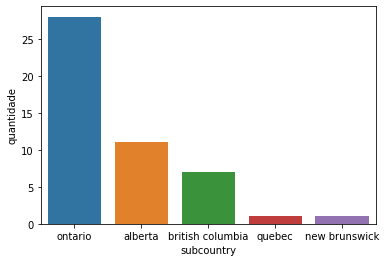

In [62]:
ax = sns.barplot(x='subcountry', 
                 y='quantidade', 
                 data=df_escopo['subcountry'].value_counts().reset_index().rename(columns={'index': 'subcountry', 
                                                                                           'subcountry': 'quantidade'})
                )

## 5.3 Analise da localidade city

In [63]:
df_escopo['city'].value_counts().reset_index().rename(columns={'index': 'city', 'city': 'quantidade'})

,city,quantidade
0,toronto,25
1,calgary,11
2,vancouver,6
3,kelowna,1
4,kitchener,1
5,ottawa,1
6,waterloo,1
7,montreal,1
8,fredericton,1


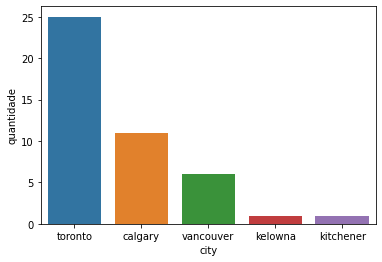

In [65]:
ax = sns.barplot(x='city', 
                 y='quantidade', 
                 data=df_escopo['city'].value_counts().reset_index().rename(columns={'index': 'city', 
                                                                                     'city': 'quantidade'}).head()
                )

## 5.4 Analise da quantidade de employees

In [69]:
df_escopo['employees'].value_counts().reset_index().rename(columns={'index': 'employees', 'employees': 'quantidade'})

,employees,quantidade
0,0,21
1,1,15
2,10,8
3,50,3
4,500,1


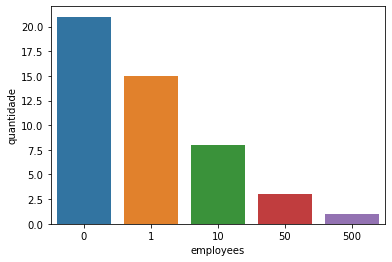

In [70]:
ax = sns.barplot(x='employees', 
                 y='quantidade', 
                 data=df_escopo['employees'].value_counts().reset_index().rename(columns={'index': 'employees', 
                                                                                          'employees': 'quantidade'}).head()
                )

In [71]:
print(f'''Pela informação que temos, {df_escopo[df_escopo['employees']>=10].shape[0]} empresas das {df_escopo.shape[0]} tem 10 ou mais funcionarios. Sendo que {df_escopo[df_escopo['employees']>=50].shape[0]} são empresas grandes com 50 ou mais funcionarios''')

Pela informação que temos, 12 empresas das 48 tem 10 ou mais funcionarios. Sendo que 4 são empresas grandes com 50 ou mais funcionarios


In [85]:
df_escopo[df_escopo['employees']>=10]['city'].value_counts()

toronto        7
vancouver      2
calgary        2
fredericton    1
Name: city, dtype: int64

In [86]:
df_escopo[df_escopo['employees']>=50]['city'].value_counts()

toronto        2
vancouver      1
fredericton    1
Name: city, dtype: int64

## 5.5 Analise do total funding

In [82]:
df_escopo['total_funding'].value_counts(dropna=False).reset_index().rename(columns={'index': 'total_funding', 'total_funding': 'quantidade'})

,total_funding,quantidade
0,NaN,37
1,-,4
2,6000000,1
3,1000000,1
4,63177,1
5,8200000,1
6,5034285,1
7,70000,1
8,690742,1


In [80]:
zero = df_escopo[(df_escopo['total_funding'].isna())|(df_escopo['total_funding']=='-')].shape[0]
media = round(df_escopo[~((df_escopo['total_funding'].isna())|(df_escopo['total_funding']=='-'))]['total_funding'].mean(),0)
minimo = round(df_escopo[~((df_escopo['total_funding'].isna())|(df_escopo['total_funding']=='-'))]['total_funding'].min(),0)
maximo = round(df_escopo[~((df_escopo['total_funding'].isna())|(df_escopo['total_funding']=='-'))]['total_funding'].max(),0)

In [81]:
print(f'''{zero} não tiveram funding ou não revelaram essa informação.
Das empresas que tiveram funding tivemos uma média de ${media}, onde o menor foi de ${minimo} e o maior foi de ${maximo}''')

41 não tiveram funding ou não revelaram essa informação.
Das empresas que tiveram funding tivemos uma média de $3008315.0, onde o menor foi de $63177 e o maior foi de $8200000


In [88]:
df_escopo[~((df_escopo['total_funding'].isna())|(df_escopo['total_funding']=='-'))]

,name,description,employees,total_funding,city,subcountry,lat,lng,name_description,topicos
12614,imtex membranes,"imtex membranes corp, is a leading innovator o...",10,6000000,toronto,ontario,43.70011,-79.41630,imtex membranes imtex membranes corp leading i...,72
12892,saltworks technologies,saltworks technologies treats the toughest wat...,50,1000000,vancouver,british columbia,49.24966,-123.11934,saltworks technologies saltworks technologies ...,72
13723,xogen technologies,"xogen technologies inc, is a privately-held ca...",10,63177,toronto,ontario,43.70011,-79.41630,xogen technologies xogen technologies inc priv...,72
16699,purlucid treatment solutions,purlucid treatment solutions is a cutting-edge...,0,8200000,calgary,alberta,51.05011,-114.08529,purlucid treatment solutions purlucid treatmen...,72
17864,acuva technologies,acuva technologies is developing ultraviolet l...,1,5034285,vancouver,british columbia,49.24966,-123.11934,acuva technologies acuva technologies developi...,72
18317,water zone technologies,our vision is to create a cost effective; tech...,1,70000,vancouver,british columbia,49.24966,-123.11934,water zone technologies vision create cost eff...,72
18576,island water technologies,"island water technologies inc, is a prince edw...",1,690742,toronto,ontario,43.70011,-79.41630,island water technologies island water technol...,72
